In [1]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from pathlib import Path,PurePath
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import util
from model import *

# import log
#
# log = log.initialise_logging("info")


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--device',type=str,default='cuda:0',help='')
parser.add_argument('--data',type=str,default='../data/METR-LA',help='data path')
parser.add_argument('--adjdata',type=str,default='../data/sensor_graph/adj_mx.pkl',help='adj data path')
parser.add_argument('--adjtype',type=str,default='doubletransition',help='adj type')
parser.add_argument('--gcn_bool',action='store_true',help='whether to add graph convolution layer')
parser.add_argument('--aptonly',action='store_true',help='whether only adaptive adj')
parser.add_argument('--addaptadj',action='store_true',help='whether add adaptive adj')
parser.add_argument('--randomadj',action='store_true',help='whether random initialize adaptive adj')
parser.add_argument('--seq_length',type=int,default=12,help='')
parser.add_argument('--nhid',type=int,default=32,help='')
parser.add_argument('--in_dim',type=int,default=2,help='inputs dimension')
parser.add_argument('--num_nodes',type=int,default=207,help='number of nodes')
parser.add_argument('--batch_size',type=int,default=64,help='batch size')
parser.add_argument('--learning_rate',type=float,default=0.001,help='learning rate')
parser.add_argument('--dropout',type=float,default=0.3,help='dropout rate')
parser.add_argument('--weight_decay',type=float,default=0.0001,help='weight decay rate')
parser.add_argument('--checkpoint',type=str, default='../garage/metr_exp1_best_2.75.pth', help='')
parser.add_argument('--plotheatmap',type=str,default='True',help='')


args = parser.parse_args('')

In [4]:
device = torch.device(args.device)

_, _, adj_mx = util.load_adj(args.adjdata, args.adjtype)
supports = [torch.tensor(i).to(device) for i in adj_mx]
if args.randomadj:
    adjinit = None
else:
    adjinit = supports[0]

if args.aptonly:
    supports = None

model =  gwnet(device, args.num_nodes, args.dropout, supports=supports, gcn_bool=True, addaptadj=True, aptinit=adjinit)
model.to(device)
model.load_state_dict(torch.load(args.checkpoint))
model.eval()
print('model load successfully')
    


model load successfully


In [5]:
dataloader = util.load_dataset(args.data, args.batch_size, args.batch_size, args.batch_size)
scaler = dataloader['scaler']
outputs = []
predList = []
realList = []
realy = torch.Tensor(dataloader['y_test']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]

for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    testx = torch.Tensor(x).to(device)
    testx = testx.transpose(1,3)
    with torch.no_grad():
        preds = model(testx).transpose(1,3)
    outputs.append(preds.squeeze())

yhat = torch.cat(outputs,dim=0)
yhat = yhat[:realy.size(0),...]


amae = []
amape = []
armse = []
for i in range(12):
    pred = scaler.inverse_transform(yhat[:,:,i])
    real = realy[:,:,i]
    predList.append(pred.cpu().detach().numpy())
    realList.append(real.cpu().detach().numpy())

    metrics = util.metric(pred,real)
    log = 'Evaluate best model on test data for horizon {:d}, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
    print(log.format(i+1, metrics[0], metrics[1], metrics[2]))
    amae.append(metrics[0])
    amape.append(metrics[1])
    armse.append(metrics[2])

log = 'On average over 12 horizons, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
print(log.format(np.mean(amae),np.mean(amape),np.mean(armse)))

Evaluate best model on test data for horizon 1, Test MAE: 2.2253, Test MAPE: 0.0534, Test RMSE: 3.8415
Evaluate best model on test data for horizon 2, Test MAE: 2.5018, Test MAPE: 0.0624, Test RMSE: 4.6268
Evaluate best model on test data for horizon 3, Test MAE: 2.6924, Test MAPE: 0.0692, Test RMSE: 5.1593
Evaluate best model on test data for horizon 4, Test MAE: 2.8419, Test MAPE: 0.0747, Test RMSE: 5.5781
Evaluate best model on test data for horizon 5, Test MAE: 2.9679, Test MAPE: 0.0794, Test RMSE: 5.9157
Evaluate best model on test data for horizon 6, Test MAE: 3.0797, Test MAPE: 0.0835, Test RMSE: 6.2019
Evaluate best model on test data for horizon 7, Test MAE: 3.1738, Test MAPE: 0.0875, Test RMSE: 6.4500
Evaluate best model on test data for horizon 8, Test MAE: 3.2575, Test MAPE: 0.0911, Test RMSE: 6.6686
Evaluate best model on test data for horizon 9, Test MAE: 3.3357, Test MAPE: 0.0942, Test RMSE: 6.8649
Evaluate best model on test data for horizon 10, Test MAE: 3.4060, Test M

In [8]:
metrics_dict = {
    'MAE': amae,
    'RMSE': armse,
    'MAPE': amape
}
metrics_df = pd.DataFrame(metrics_dict)

In [9]:
metrics_df['Horizon'] = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [11]:
cols = list(metrics_df.columns.values)
metrics_df = metrics_df[['Horizon', 'MAE', 'RMSE', 'MAPE']]

In [12]:
metrics_df

,Horizon,MAE,RMSE,MAPE
0,5,2.225288,3.841515,0.053364
1,10,2.501814,4.626835,0.062413
2,15,2.692390,5.159286,0.069204
3,20,2.841906,5.578058,0.074707
4,25,2.967905,5.915726,0.079354
5,30,3.079721,6.201948,0.083514
6,35,3.173813,6.450029,0.087531
7,40,3.257502,6.668579,0.091053
8,45,3.335690,6.864866,0.094197
9,50,3.405976,7.027558,0.096853


In [13]:
def plot_time(df, dataset_name='METR-LA', id_range=5,  start=0, end=12, horizon=0):
    fig, ax = plt.subplots(figsize=(30, 10))
    for i in range(id_range):
        ax.plot(df[i][start:end], label='Node ID: {}'.format(i))
    ax.legend()
    ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
    ax.set_ylabel('Speed')
    ax.set_xlabel('Time Intervals(1 interval=5mins) at {} horizon'.format(horizon+1))
    # ax.set_xlabel('Time Intervals(1 interval=5mins)')
    plt.show()

In [14]:
def plot_time_compare(predList, realList, dataset_name='METR-LA', start=0, end=12, node_id=0, horizon=0):
  df_pred = pd.DataFrame(predList[horizon])
  df_real = pd.DataFrame(realList[horizon])
  fig, ax = plt.subplots(figsize=(30, 10))
  ax.plot(df_pred[node_id][start:end], label='Pred horizon ID: {}'.format(1))
  ax.plot(df_real[node_id][start:end], label='Real Node ID: {}'.format(1))
  ax.legend()
  ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
  ax.set_ylabel('Speed')
  ax.set_xlabel('Time Intervals(1 interval=5mins) at {} horizon'.format(horizon+1))
  plt.show()

In [15]:
print(predList[0].shape)
print(len(predList[0]))
print(len(predList))

(6850, 207)
6850
12


In [26]:
print(realList[0].shape)
print(realList[11])


(6850, 207)
[[60.333332 57.       68.666664 ... 64.111115 64.888885 63.88889 ]
 [66.125    59.375    68.375    ... 64.875    64.875    65.375   ]
 [66.375    65.125    69.125    ... 65.625    60.25     64.5     ]
 ...
 [67.       59.666668 69.55556  ... 63.333332 67.44444  61.22222 ]
 [66.75     62.25     66.       ... 63.       67.875    63.5     ]
 [65.111115 66.888885 66.77778  ... 63.555557 68.666664 61.77778 ]]


In [21]:
df_pred_horizon = pd.DataFrame(predList[0])
df_real_horizon = pd.DataFrame(realList[0])

In [32]:
df_pred = pd.DataFrame(predList[0])
#df_pred[0][0:288*3]
df_pred

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,63.088158,61.929447,66.850616,58.920753,65.545876,57.261089,64.169807,62.562561,62.127384,66.281647,...,39.244728,64.898041,53.524704,61.873699,61.904736,60.535290,65.258942,64.463394,63.901104,62.268887
1,63.375595,61.366928,66.603027,58.355442,65.476578,56.638145,63.600639,62.498684,61.688927,65.797974,...,39.182480,65.039207,54.676731,62.764984,60.493347,60.494225,64.297470,64.276077,64.104652,62.171101
2,63.658211,61.530514,66.780212,58.150074,65.421227,56.146587,64.166801,62.314529,62.176445,66.395737,...,39.898640,65.179428,54.987061,62.164291,61.789661,60.161095,65.060226,63.989902,63.960178,62.771240
3,63.660336,61.336494,66.679543,57.639511,65.542786,54.726276,64.475098,62.150478,62.849922,66.676918,...,41.248745,65.298897,55.187321,61.847027,61.865005,59.901077,64.803551,63.986221,63.861053,63.168163
4,63.685738,60.930542,66.613487,57.931141,65.780617,54.326202,64.318367,62.256153,62.877640,67.024033,...,41.733627,65.578659,55.314754,62.574127,62.429268,60.311615,65.471588,64.526817,63.499859,63.371239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845,66.522415,65.864082,68.571747,58.607628,60.685257,56.526672,62.224865,64.995987,62.767578,66.767441,...,47.453415,68.504730,64.284073,61.896255,67.097008,64.046936,68.081459,65.958649,67.641640,63.239750
6846,66.283142,65.960785,68.277756,58.019413,60.550304,56.207787,62.025249,65.104034,62.177429,66.518333,...,47.635319,68.516098,64.080452,61.158066,66.767189,62.408371,67.668655,66.180748,67.799721,63.016953
6847,66.666573,65.877357,68.257294,57.726372,60.981277,57.270073,63.020676,64.819206,62.524902,66.754623,...,48.461784,68.625870,64.087868,61.277897,66.962738,63.668320,67.780556,66.193222,67.792480,63.194466
6848,66.457359,66.022865,67.893898,58.443966,60.542984,58.690762,62.850426,65.041275,62.084667,66.539368,...,49.649853,68.652939,63.623741,62.058830,66.692947,63.609634,68.001938,66.213898,67.779076,62.939735


In [36]:
df_pred[0][0:2]

0    63.088158
1    63.375595
Name: 0, dtype: float32

In [24]:
df_pred_horizon.head()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,63.088158,61.929447,66.850616,58.920753,65.545876,57.261089,64.169807,62.562561,62.127384,66.281647,...,39.244728,64.898041,53.524704,61.873699,61.904736,60.535290,65.258942,64.463394,63.901104,62.268887
1,63.375595,61.366928,66.603027,58.355442,65.476578,56.638145,63.600639,62.498684,61.688927,65.797974,...,39.182480,65.039207,54.676731,62.764984,60.493347,60.494225,64.297470,64.276077,64.104652,62.171101
2,63.658211,61.530514,66.780212,58.150074,65.421227,56.146587,64.166801,62.314529,62.176445,66.395737,...,39.898640,65.179428,54.987061,62.164291,61.789661,60.161095,65.060226,63.989902,63.960178,62.771240
3,63.660336,61.336494,66.679543,57.639511,65.542786,54.726276,64.475098,62.150478,62.849922,66.676918,...,41.248745,65.298897,55.187321,61.847027,61.865005,59.901077,64.803551,63.986221,63.861053,63.168163
4,63.685738,60.930542,66.613487,57.931141,65.780617,54.326202,64.318367,62.256153,62.877640,67.024033,...,41.733627,65.578659,55.314754,62.574127,62.429268,60.311615,65.471588,64.526817,63.499859,63.371239


In [27]:
#  24hrs=288*1, 48hrs=288*2, 72hrs=288*3
start = 0
end = 288*3  #108
horizon = 11
node_id = 5

In [28]:
df_pred = pd.DataFrame(predList[horizon])
df_real = pd.DataFrame(realList[horizon])

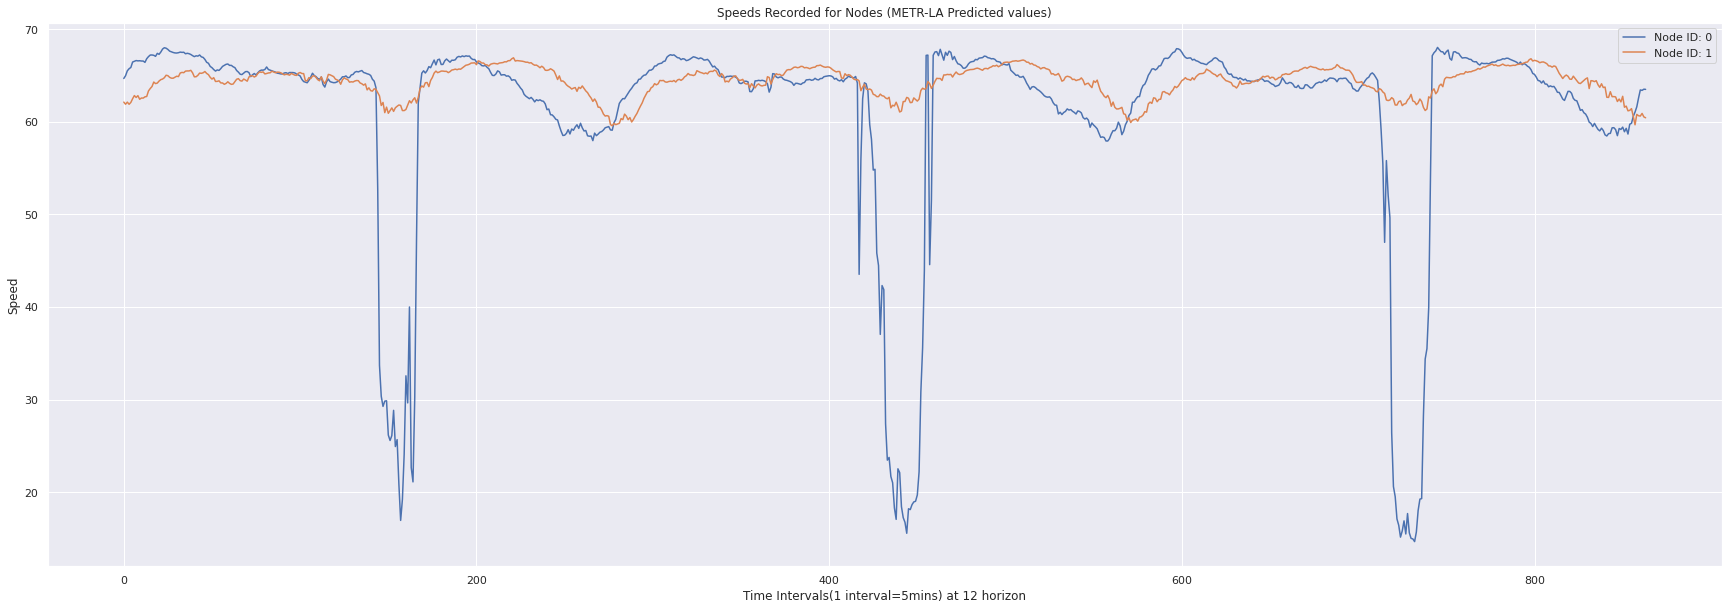

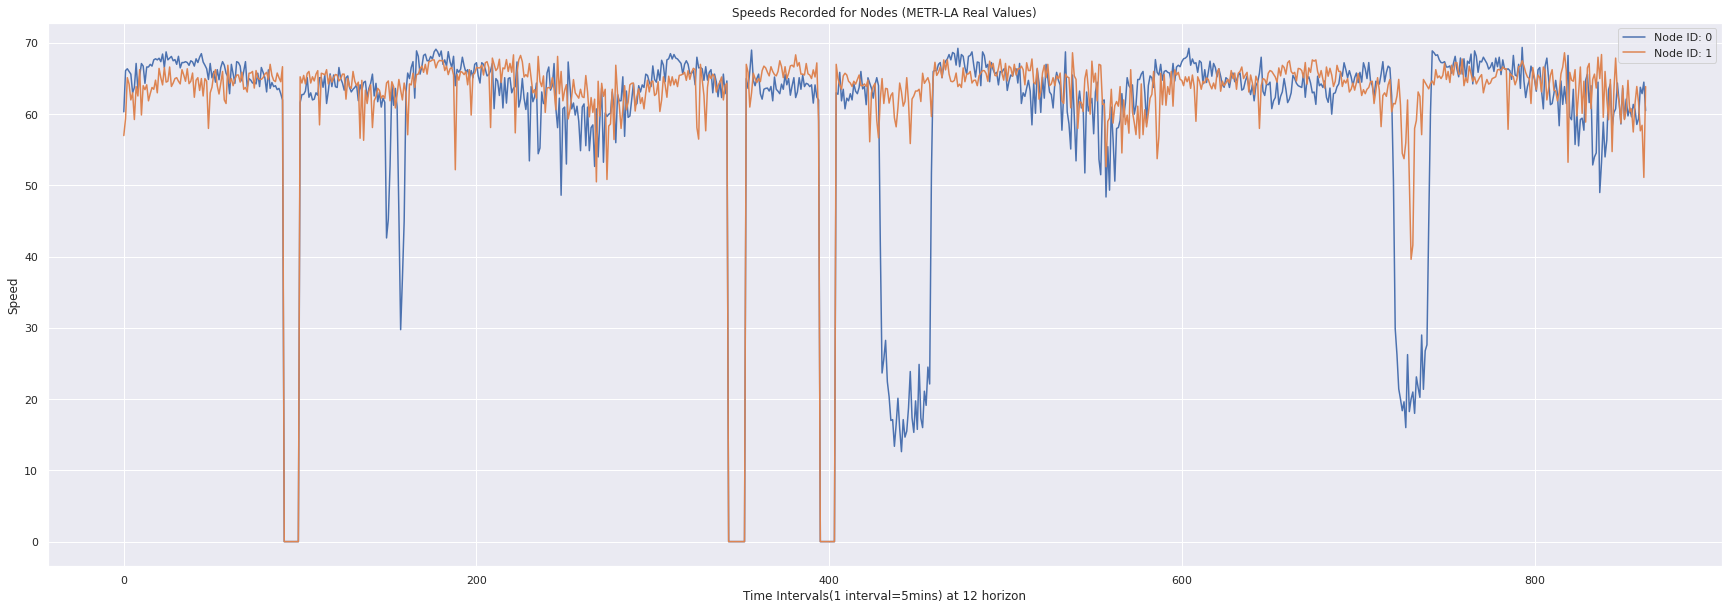

In [29]:
plot_time(df=df_pred, dataset_name='METR-LA Predicted values', id_range=2, start=start, end=end, horizon=horizon) 
plot_time(df=df_real, dataset_name='METR-LA Real Values', id_range=2, start=start, end=end, horizon=horizon)


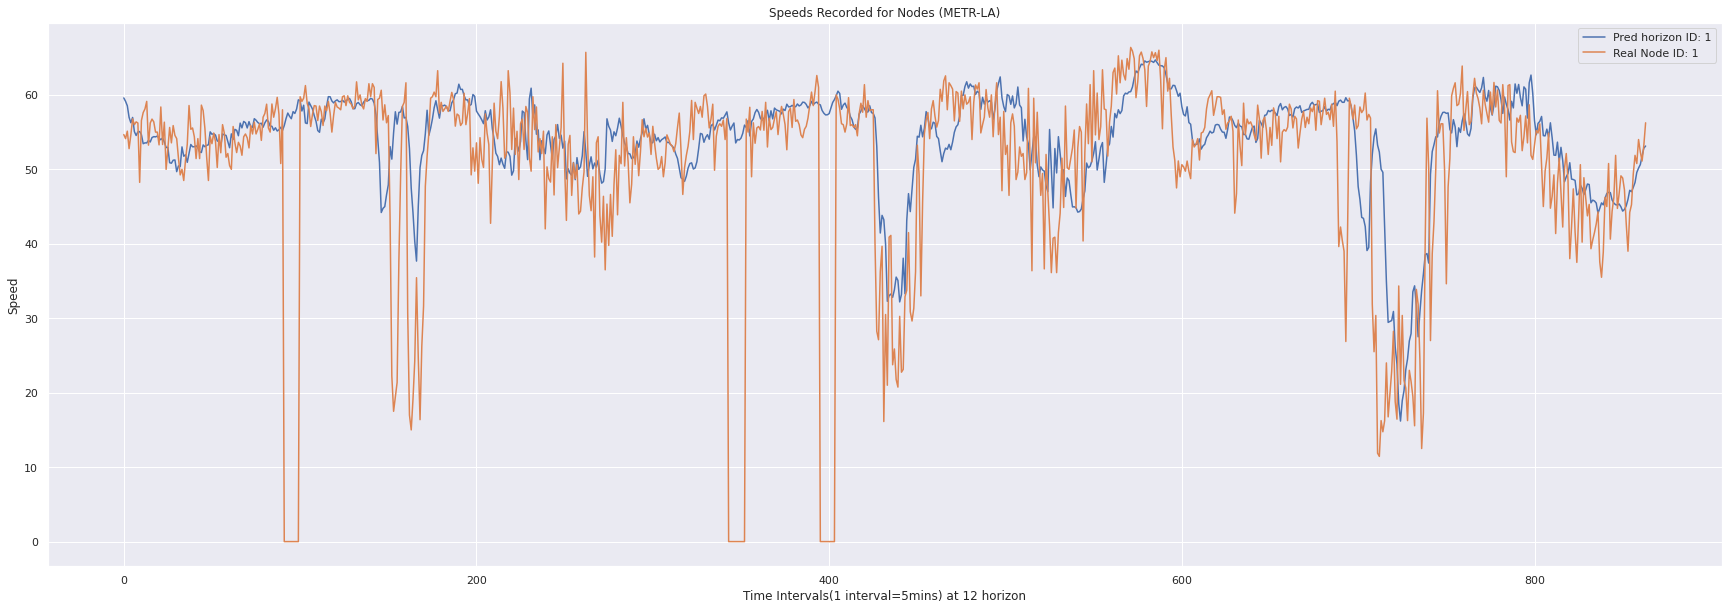

In [30]:
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=node_id, horizon=horizon)

### Fig 3. Prediction data vs Test data for Node 1 (72hr period)
- The Model is able to predict the correct values. However, it cannot account for when there is no traffic being recorded at the node

In [37]:
print('The standard deviation values for the Predicted nodes are\n', df_pred.std()[:5])
print('The standard deviation values for the Predicted nodes are\n', df_real.std()[:5])

The standard deviation values for the Predicted nodes are
 0    12.606090
1     2.206787
2     9.401220
3     8.943735
4    14.785750
dtype: float32
The standard deviation values for the Predicted nodes are
 0    22.086756
1    19.356901
2    21.309414
3    18.040911
4    21.634510
dtype: float32


In [38]:
print('The mean values for the Predicted nodes are\n', df_pred.mean()[:5])
print('The mean values for the Predicted nodes are\n', df_real.mean()[:5])

The mean values for the Predicted nodes are
 0    61.214996
1    64.785736
2    65.223633
3    52.840046
4    48.378998
dtype: float32
The mean values for the Predicted nodes are
 0    54.779102
1    58.223618
2    58.480721
3    47.261707
4    41.741451
dtype: float32


In [39]:
adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)

In [40]:
device = torch.device('cpu')
adp.to(device)
adp = adp.cpu().detach().numpy()

In [41]:
adp = adp*(1/np.max(adp))
adp_tempt = adp[:50, :50]
df_adj = pd.DataFrame(adp_tempt)

In [42]:
df_adj.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.025966,0.031810,0.025966,0.025966,0.025966,0.025966,0.025966,0.029608,0.027975,0.033153,...,0.025966,0.025966,0.033797,0.028663,0.046485,0.038919,0.025966,0.025966,0.025966,0.025966
1,0.039418,0.023852,0.021887,0.021887,0.045345,0.021887,0.036337,0.025254,0.022063,0.021887,...,0.021887,0.021887,0.053822,0.030350,0.047025,0.036714,0.021887,0.027309,0.021887,0.024405
2,0.024917,0.030858,0.024917,0.037559,0.028007,0.029509,0.024917,0.030171,0.026200,0.024917,...,0.024917,0.024917,0.105837,0.026902,0.030472,0.027005,0.026376,0.024917,0.024917,0.030456
3,0.033445,0.030238,0.025135,0.025135,0.025135,0.025135,0.025135,0.029424,0.025135,0.025135,...,0.025135,0.025135,0.032503,0.037765,0.043906,0.034076,0.025135,0.029524,0.025135,0.025135
4,0.026462,0.030452,0.035747,0.050473,0.026462,0.033496,0.026462,0.026462,0.029806,0.026462,...,0.089146,0.028266,0.026462,0.036355,0.026462,0.029657,0.026462,0.026462,0.051133,0.026462


<AxesSubplot:>

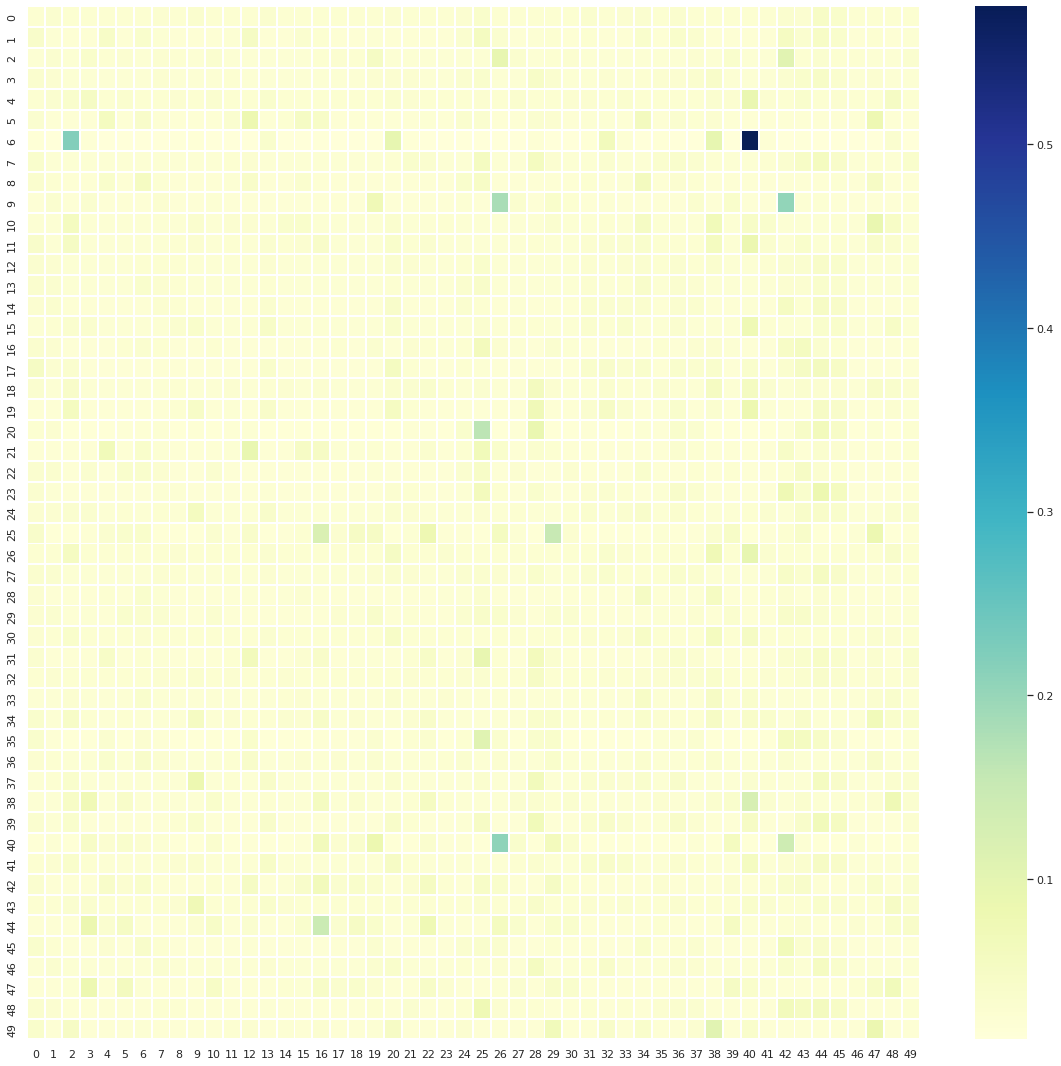

In [43]:
sns.set (rc = {'figure.figsize':(20, 19)})
sns.heatmap(df_adj, linewidths=.9, cmap='YlGnBu')
# plt.savefig("./emb"+ '.pdf')


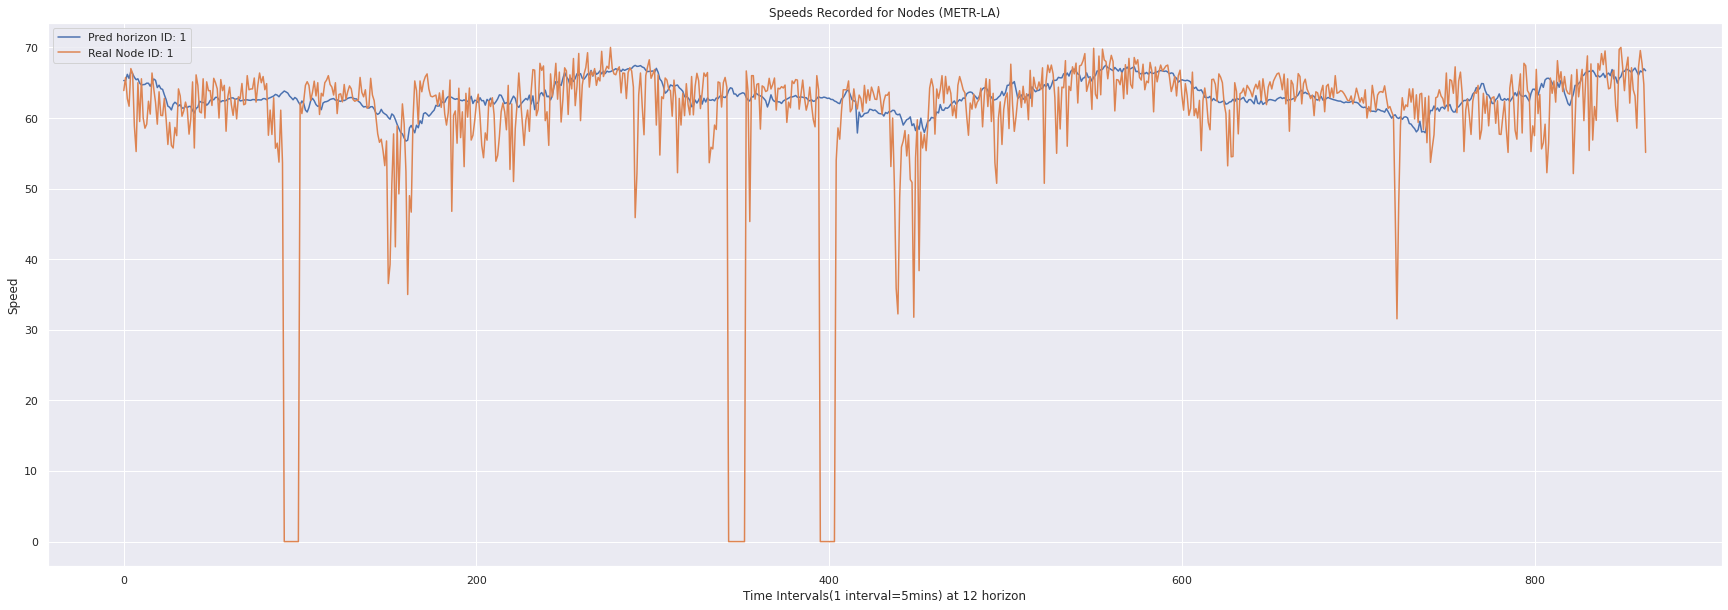

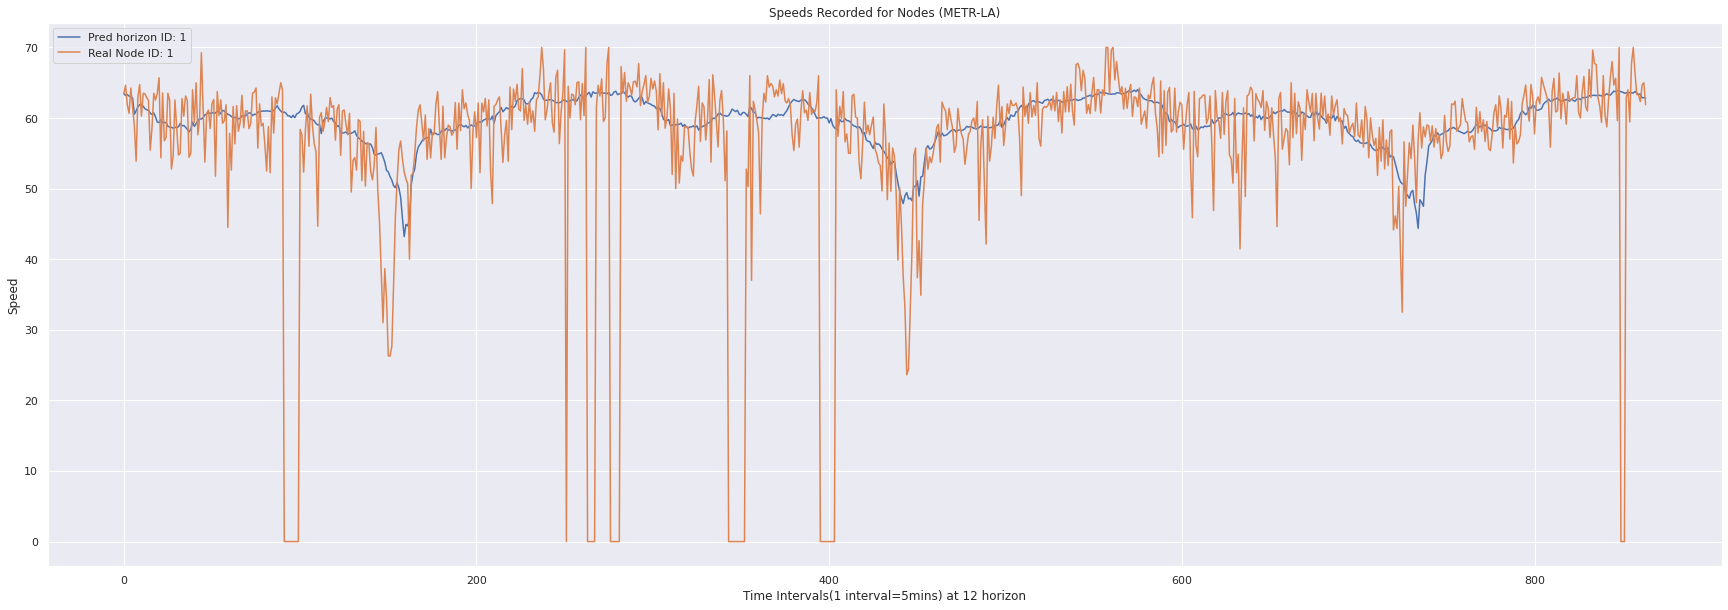

In [67]:
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=65, horizon=horizon)
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=30, horizon=horizon)

## Fig 4 Real and Pred plots for node 65 and 30 as seen in the heatmap
- Node 65 influences node 30 as seen in the similar dips in their graphs.


In [29]:
def printPrincipalDiagonal(mat, n):
    values = []
    for i in range(n):
        for j in range(n):
 
            # Condition for principal diagonal
            if (i == j):
                values.append(mat[i][j])
    return values


In [34]:
values = printPrincipalDiagonal(adp, 207)

In [45]:
data = str(Path(sys.path[0] + '/data/sensor_graph'))
df_met = pd.read_csv(data + '/graph_sensor_locations.csv')

In [87]:
df_met['magnitude'] = values
df_met['magnitude'] = (df_met['magnitude']/ df_met['magnitude'].max()) 

In [88]:
df_met.to_csv(data+'/test_metrla.csv', index=False)

In [89]:
df_met['magnitude'].max()

1.0

In [90]:
df_met['magnitude'].min()

0.16255197830672016

In [91]:
df_met['magnitude'].median()

0.24290553340714577

In [85]:
df_met.head(50)

,index,sensor_id,latitude,longitude,magnitude
0,0,773869,34.15497,-118.31829,23.344682
1,1,767541,34.11621,-118.23799,21.988673
2,2,767542,34.11641,-118.23819,33.861742
3,3,717447,34.07248,-118.26772,23.951456
4,4,717446,34.07142,-118.26572,30.926379
5,5,717445,34.06913,-118.25932,21.346582
6,6,773062,34.05368,-118.23369,16.255198
7,7,767620,34.13486,-118.22932,20.257564
8,8,737529,34.20264,-118.47352,26.682137
9,9,717816,34.15562,-118.46860,21.231682


In [3]:






# if args.plotheatmap == "True":
#     adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)
#     device = torch.device('cpu')
#     adp.to(device)
#     adp = adp.cpu().detach().numpy()
#     adp = adp*(1/np.max(adp))
#     adp = adp[:50, :50]
#     df = pd.DataFrame(adp)
#     sns.heatmap(df, linewidths=.5, cmap='YlGnBu')
#     plt.savefig("./emb"+ '.pdf')



In [92]:
y12 = realy[:,99,11].cpu().detach().numpy()
yhat12 = scaler.inverse_transform(yhat[:,99,11]).cpu().detach().numpy()

y3 = realy[:,99,2].cpu().detach().numpy()
yhat3 = scaler.inverse_transform(yhat[:,99,2]).cpu().detach().numpy()

df2 = pd.DataFrame({'real12':y12,'pred12':yhat12, 'real3': y3, 'pred3':yhat3})
df2.to_csv('./wave.csv',index=False)